<a href="https://colab.research.google.com/github/GuCuChiara/Skin-Cancer-Classification/blob/main/Skin_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer Classification: (FIRST MODEL)


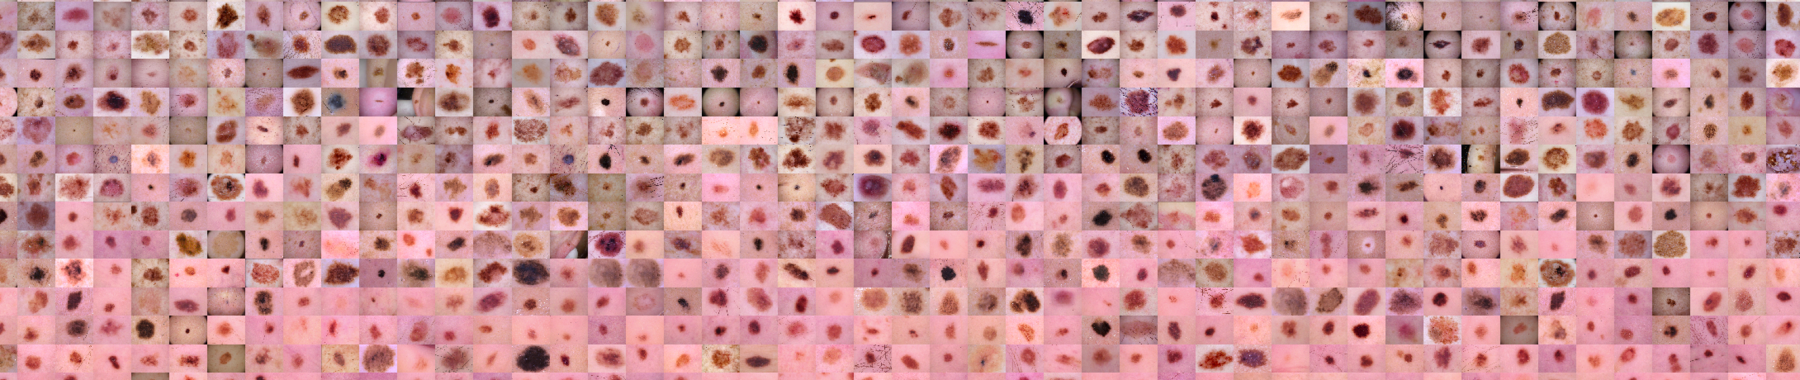

The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions.

Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018).

https://www.nature.com/articles/sdata2018161

* The HAM10000 (“Human Against Machine with 10000 training images”) dataset is a large collection of dermatoscopic images from different populations acquired and stored by different modalities.

* The final dataset consists of 10015 dermatoscopic images which are released as a training set for academic machine learning purposes and are publicly available through the ISIC archive.

* This benchmark dataset can be used for machine learning and for comparisons with human experts.

* Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions.

* More than 50% of lesions have been confirmed by pathology, while the ground truth for the rest of the cases was either follow-up, expert consensus, or confirmation by in-vivo confocal microscopy.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [ ]:
import numpy as np
import os
import cv2
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

%matplotlib inline


In [ ]:
print(tf.__version__)

2.8.2


In [ ]:
import pathlib

data_dir = '/content/gdrive/My Drive/Colab Notebooks/Clasificador/data/entrenamiento'
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6129


# Data Visualization

In [ ]:
labels = ['Actinic_Keratosis', 'Basal_cell_carcinoma', 'Benign_keratosis', 'Dermatofibroma', 'Melanocytic_nevi', 'Melanoma', 'Squamous_cell_carcinoma', 'Vascular_skin_lesions']
image_size = 224
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (image_size, image_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
data = get_data(data_dir)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


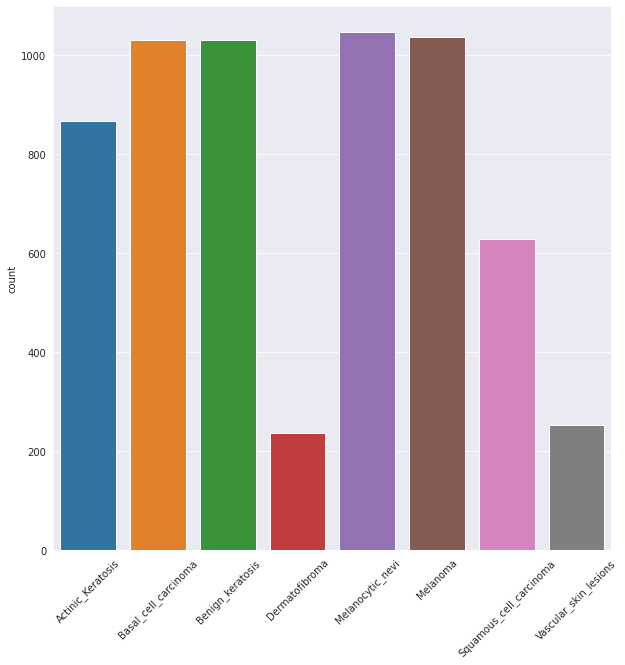

In [ ]:
import seaborn as sns
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('darkgrid')
chart = sns.countplot(l)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.figure.set_size_inches(10,10)
plt.show()

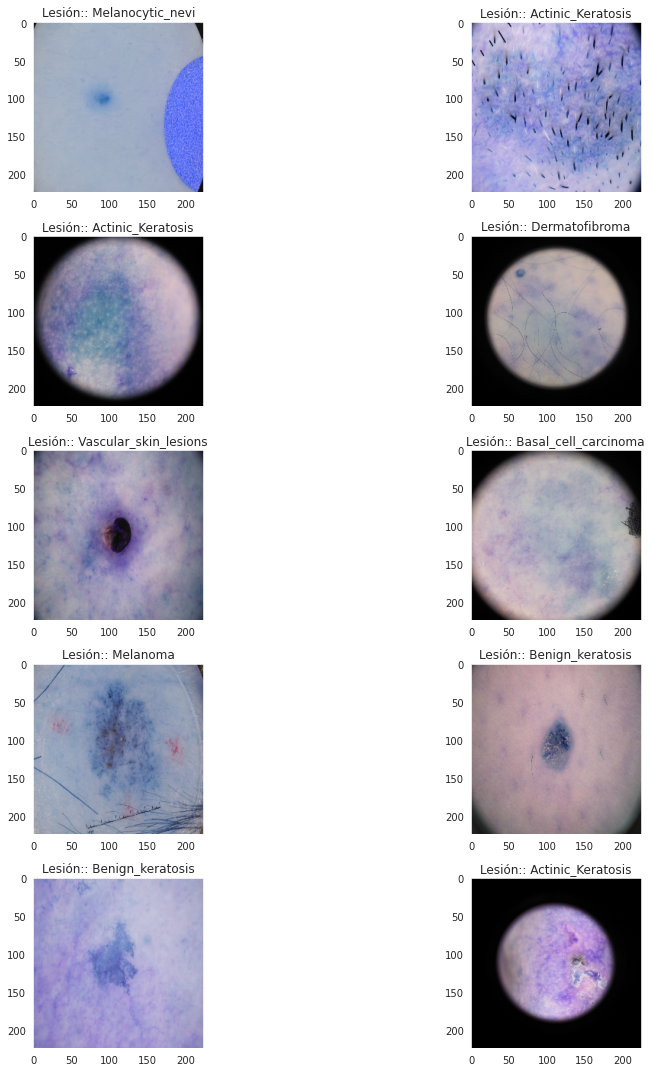

In [ ]:
import random
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Lesión:: '+labels[data[l][1]])

plt.tight_layout()

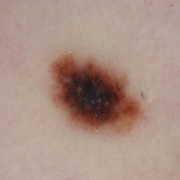

In [ ]:
from PIL import Image
Melanoma = list(data_dir.glob('Melanoma/*'))
newsize = (180, 180)
im0= PIL.Image.open(str(Melanoma[4]))
im1 = im0.resize(newsize)
im1

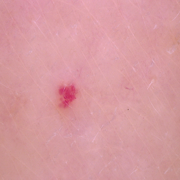

In [ ]:
from PIL import Image
Vascular_skin_lesions = list(data_dir.glob('Vascular_skin_lesions/*'))
newsize = (180, 180)
im0= PIL.Image.open(str(Vascular_skin_lesions[6]))
im1 = im0.resize(newsize)
im1

# Configuración de parámetros

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
num_classes = 8

# It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6129 files belonging to 8 classes.
Using 4904 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6129 files belonging to 8 classes.
Using 1225 files for validation.


# You can find the class names in the class_names attribute on these datasets:

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Actinic_Keratosis', 'Basal_cell_carcinoma', 'Benign_keratosis', 'Dermatofibroma', 'Melanocytic_nevi', 'Melanoma', 'Squamous_cell_carcinoma', 'Vascular_skin_lesions']


# Visualize the data
Here are the first nine images from the training dataset.

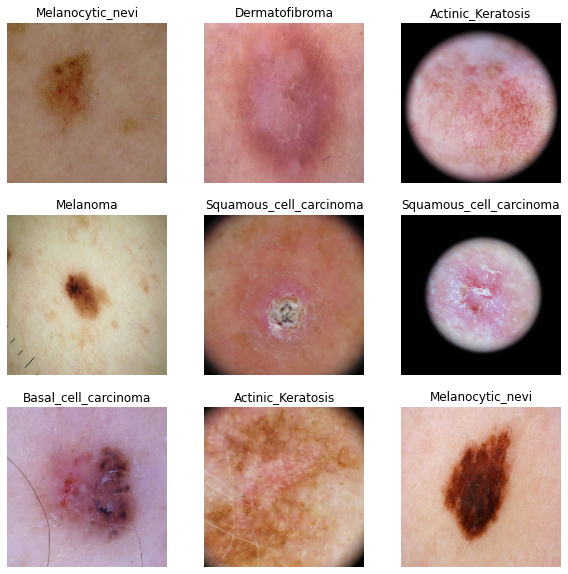

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You can train a model using these datasets by passing them to model.fit (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on either of these tensors to convert them to a numpy.ndarray.

# Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.021578928 0.87885946


Or, you can include the layer inside your model definition to simplify deployment. You will use the second approach here.

# Configure the dataset for performance
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

**Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

**Dataset.prefetch** overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Train a model
**The Sequential model consists of:**
* three convolution blocks (tf.keras.layers.Conv2D)
* with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them.

There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu').

This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created.


In [ ]:
cnn-model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [ ]:
cnn-model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               3277056   
                                                                 
 dense_9 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 17,993,800
Trainable params: 3,279,112
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = cnn-model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)
model.summary()
target_dir = '/content/gdrive/My Drive/Colab Notebooks/Clasificador/modelo/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
model.save('/content/gdrive/My Drive/Colab Notebooks/Clasificador/modelo/cnn.h5')
model.save_weights('/content/gdrive/My Drive/Colab Notebooks/Clasificador/modelo/cnn-pesos.h5')

Epoch 1/50
120/120 [==============================] - 32s 256ms/step - loss: 1.4474 - accuracy: 0.4958 - val_loss: 1.4594 - val_accuracy: 0.4698
Epoch 2/50
120/120 [==============================] - 17s 142ms/step - loss: 0.8860 - accuracy: 0.6643 - val_loss: 1.4625 - val_accuracy: 0.5104
Epoch 3/50
120/120 [==============================] - 17s 141ms/step - loss: 0.6104 - accuracy: 0.7698 - val_loss: 1.5038 - val_accuracy: 0.5000
Epoch 4/50
120/120 [==============================] - 17s 142ms/step - loss: 0.4159 - accuracy: 0.8445 - val_loss: 1.6253 - val_accuracy: 0.5073
Epoch 5/50
120/120 [==============================] - 17s 142ms/step - loss: 0.3157 - accuracy: 0.8911 - val_loss: 1.8992 - val_accuracy: 0.4792
Epoch 6/50
120/120 [==============================] - 17s 141ms/step - loss: 0.2358 - accuracy: 0.9193 - val_loss: 1.9173 - val_accuracy: 0.4979
Epoch 7/50
120/120 [==============================] - 17s 142ms/step - loss: 0.1852 - accuracy: 0.9391 - val_loss: 2.3600 - val_ac

In [ ]:
test_results = cnn-model.evaluate(val_ds)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

In [ ]:
print(history.history.keys())

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('cnn model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('cnn model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

--------------------------------------------------------------------------------

# Transfer Learning modelo: **VGG16** solo agregamos capa Dense

In [ ]:
#TRANSFER LEARNING CON VGG16 COMO CAPA BASE
#from tensorflow.keras.applications import VGG16
#num_classes = 8
#conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(180,180,3))
#conv_base.trainable = False

#model = tf.keras.Sequential([
#  conv_base,
#  tf.keras.layers.Flatten(),
#  tf.keras.layers.Dense(256, activation='relu'),
#  tf.keras.layers.Dense(num_classes, activation='softmax')
#])

In [ ]:
#TRANSFER LEARNING CON VGG16 COMO CAPA BASE: custom_model_VGG16
image_input = Input(shape= (img_width, img_height, 3))
model = VGG16(input_tensor=image_input, include_top=True, weights='imagenet')
model.summary()
last_layer = model.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_model_VGG16 = Model(image_input, out)

for layer in custom_model_VGG16.layers[:-1]:
	layer.trainable = False

custom_model_VGG16.summary()

custom_model_VGG16.compile(
		loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
		optimizer='adam',
		metrics=['accuracy'])



553476096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
model_history = custom_model_VGG16.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)
target_dir = '/content/gdrive/My Drive/Colab Notebooks/Clasificador/modelo/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
custom_model_VGG16.save('/content/gdrive/My Drive/Colab Notebooks/Clasificador/modelo/custom_model_VGG16.h5')
custom_model_VGG16.save_weights('/content/gdrive/My Drive/Colab Notebooks/Clasificador/modelo/custom_model_VGG16_pesos.h5')

Epoch 1/20
 40/154 [======>.......................] - ETA: 6:25 - loss: 2.0630 - accuracy: 0.2891

In [ ]:
test_results = custom_model_VGG16.evaluate(val_ds)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

39/39 [==============================] - 6s 149ms/step - loss: 1.8296 - accuracy: 0.4424
Test results - Loss: 1.829613208770752 - Accuracy: 44.24489736557007%


In [ ]:
print(model_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


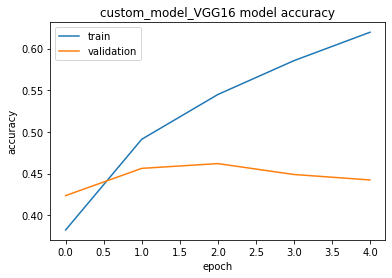

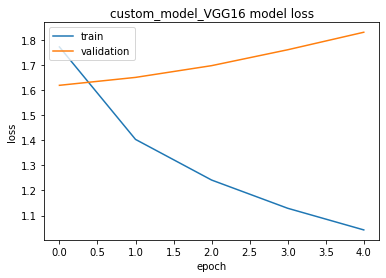

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('custom_model_VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('custom_model_VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predicción usando el modelo entrenado:


Actinic_Keratosis


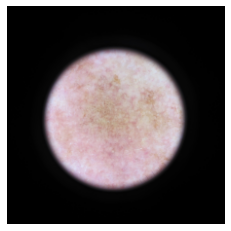

In [ ]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model

names = ['Actinic_Keratosis', 'Basal_cell_carcinoma', 'Benign_keratosis',
         'Dermatofibroma', 'Melanocytic_nevi', 'Melanoma', 'Squamous_cell_carcinoma', 'Vascular_skin_lesions']

modelt = load_model("/content/gdrive/My Drive/Colab Notebooks/Clasificador/modelo/custom_model_VGG16.h5")
#modelt = custom_model

imaget_path = '/content/gdrive/My Drive/Colab Notebooks/Clasificador/predict/AK-ISIC_0031228.jpg'
imaget=cv2.resize(cv2.imread(imaget_path), (img_width, img_height), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print(names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Predicción de varias imágenes:

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
longitud, altura = 224, 224
modelo = '/content/gdrive/My Drive/Colab Notebooks/Clasificador/modelo/custom_model_VGG16.h5'
pesos_modelo = '/content/gdrive/My Drive/Colab Notebooks/Clasificador/modelo/custom_model_VGG16_pesos.h5'
cnn = load_model(modelo)
cnn.load_weights(pesos_modelo)

def predict(file):
  x = load_img(file, target_size=(longitud, altura))
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0)
  array = cnn.predict(x)
  result = array[0]
  answer = np.argmax(result)
  if answer == 0:
    print("La predicción es: Actinic_keratosis_AK = " + str(answer) )
  elif answer == 1:
    print("La predicción es: Basal_cell_carcinoma_BCC = " + str(answer) )
  elif answer == 2:
    print("La predicción es: Benign_keratosis_BKL = " + str(answer) )
  elif answer == 3:
    print("La predicción es: Dermatofibroma_DF = " + str(answer) )
  elif answer == 4:
    print("La predicción es: Melanocytic_nevus_NV = " + str(answer) )
  elif answer == 5:
    print("La predicción es: Melanoma_MEL = " + str(answer) )
  elif answer == 6:
    print("La predicción es: Squamous_cell_carcinoma_SCC = " + str(answer) )
  elif answer == 7:
    print("La predicción es: Vascular_lesion_VASC = " + str(answer) )
  #elif answer == 4:
   # print("La predicción es: ...!")
  #elif answer == 5:
   # print("La predicción es: ...!")
  return answer

predict('/content/gdrive/My Drive/Colab Notebooks/Clasificador/predict/AK-ISIC_0031228.jpg')
predict('/content/gdrive/My Drive/Colab Notebooks/Clasificador/predict/BCC-ISIC_0026156.jpg')
predict('/content/gdrive/My Drive/Colab Notebooks/Clasificador/predict/BKL-ISIC_0012773_downsampled.jpg')
predict('/content/gdrive/My Drive/Colab Notebooks/Clasificador/predict/DF-ISIC_0031457.jpg')
predict('/content/gdrive/My Drive/Colab Notebooks/Clasificador/predict/MEL-ISIC_0000393_downsampled.jpg')
predict('/content/gdrive/My Drive/Colab Notebooks/Clasificador/predict/VASC-ISIC_0031270.jpg')
predict('/content/gdrive/My Drive/Colab Notebooks/Clasificador/predict/NV-ISIC_0000114_downsampled.jpg')
predict('/content/gdrive/My Drive/Colab Notebooks/Clasificador/predict/SCC-ISIC_0028763.jpg')

La predicción es: Actinic_keratosis_AK = 0
La predicción es: Melanocytic_nevus_NV = 4
La predicción es: Benign_keratosis_BKL = 2
La predicción es: Melanocytic_nevus_NV = 4
La predicción es: Melanocytic_nevus_NV = 4
La predicción es: Vascular_lesion_VASC = 7
La predicción es: Melanocytic_nevus_NV = 4
La predicción es: Squamous_cell_carcinoma_SCC = 6


6

# Matriz de confusión y métricas de desempeño:


Found 80 images belonging to 8 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           0     0.7500    0.3000    0.4286        10
           1     0.2414    0.7000    0.3590        10
           2     1.0000    0.1000    0.1818        10
           3     0.7143    0.5000    0.5882        10
           4     0.4706    0.8000    0.5926        10
           5     1.0000    0.3000    0.4615        10
           6     0.5455    0.6000    0.5714        10
           7     0.8750    0.7000    0.7778        10

    accuracy                         0.5000        80
   macro avg     0.6996    0.5000    0.4951        80
weighted avg     0.6996    0.5000    0.4951        80



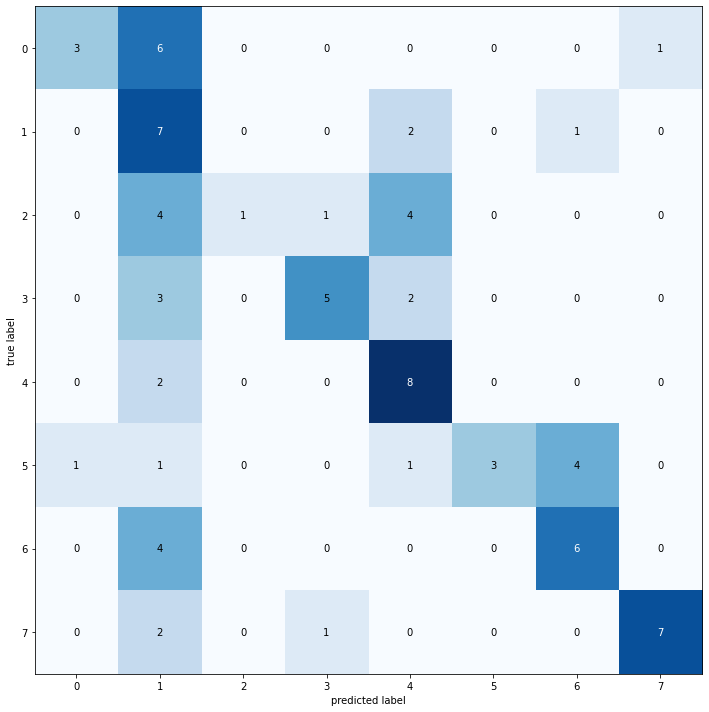

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


names = ['Actinic_Keratosis', 'Basal_cell_carcinoma', 'Benign_keratosis',
         'Dermatofibroma', 'Melanocytic_nevi', 'Melanoma', 'Squamous_cell_carcinoma', 'Vascular_skin_lesions']


#test_data_dir = '/content/gdrive/My Drive/Colab Notebooks/Clasificador/predict'
test_data_dir = '/content/gdrive/My Drive/Colab Notebooks/Clasificador/data/test'

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

custom_Model= load_model("/content/gdrive/My Drive/Colab Notebooks/Clasificador/modelo/custom_model_VGG16.h5")
#modelt = custom_model

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes


matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(10,10), show_normed=False) #class_names = names,
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))

In [ ]:
confusion_matrix(y_real, y_pred)

array([[3, 6, 0, 0, 0, 0, 0, 1],
       [0, 7, 0, 0, 2, 0, 1, 0],
       [0, 4, 1, 1, 4, 0, 0, 0],
       [0, 3, 0, 5, 2, 0, 0, 0],
       [0, 2, 0, 0, 8, 0, 0, 0],
       [1, 1, 0, 0, 1, 3, 4, 0],
       [0, 4, 0, 0, 0, 0, 6, 0],
       [0, 2, 0, 1, 0, 0, 0, 7]])

In [ ]:
from sklearn.utils.multiclass import unique_labels
unique_labels(y_real)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [ ]:
import pandas as pd

print(pd.__version__)

1.3.5


In [ ]:
from numpy.core.numeric import indices
def plot(y_real, y_pred):
  labels = names
  column= [f'Predicted {label}' for label in labels]
  indices = [f'Actual {label}' for label in labels]
  table= pd.DataFrame(confusion_matrix(y_real, y_pred),
                      columns=column, index=indices)
  return table

In [ ]:
plot(y_real, y_pred)

,Predicted Actinic_Keratosis,Predicted Basal_cell_carcinoma,Predicted Benign_keratosis,Predicted Dermatofibroma,Predicted Melanocytic_nevi,Predicted Melanoma,Predicted Squamous_cell_carcinoma,Predicted Vascular_skin_lesions
Actual Actinic_Keratosis,3,6,0,0,0,0,0,1
Actual Basal_cell_carcinoma,0,7,0,0,2,0,1,0
Actual Benign_keratosis,0,4,1,1,4,0,0,0
Actual Dermatofibroma,0,3,0,5,2,0,0,0
Actual Melanocytic_nevi,0,2,0,0,8,0,0,0
Actual Melanoma,1,1,0,0,1,3,4,0
Actual Squamous_cell_carcinoma,0,4,0,0,0,0,6,0
Actual Vascular_skin_lesions,0,2,0,1,0,0,0,7


In [ ]:
predict_folder_path="/content/gdrive/My Drive/Colab Notebooks/Clasificador/predict"
predicts=[]
img_size=160
for img in os.listdir(predict_folder_path):
    img = cv2.imread(os.path.join(predict_folder_path,img))
    #img_gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_resize= cv2.resize(img,(img_size,img_size))
    predicts.append(img_resize)

In [ ]:
predicts = np.array(predicts)
print(predicts.shape)

(48, 160, 160, 3)


La predicción es: Basal_cell_carcinoma_BCC = 1
(160, 160, 3)


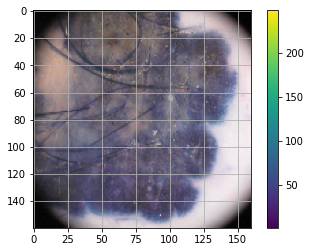

In [ ]:
predict('/content/gdrive/My Drive/Colab Notebooks/Clasificador/predict/MEL-ISIC_0000412_downsampled.jpg') #predicción
print(predicts[1].shape)
plt.figure()
plt.imshow(np.squeeze(predicts[1]))
plt.colorbar()
plt.grid(True)
plt.show()

Found 80 images belonging to 8 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           0     0.7500    0.3000    0.4286        10
           1     0.2414    0.7000    0.3590        10
           2     1.0000    0.1000    0.1818        10
           3     0.7143    0.5000    0.5882        10
           4     0.4706    0.8000    0.5926        10
           5     1.0000    0.3000    0.4615        10
           6     0.5455    0.6000    0.5714        10
           7     0.8750    0.7000    0.7778        10

    accuracy                         0.5000        80
   macro avg     0.6996    0.5000    0.4951        80
weighted avg     0.6996    0.5000    0.4951        80



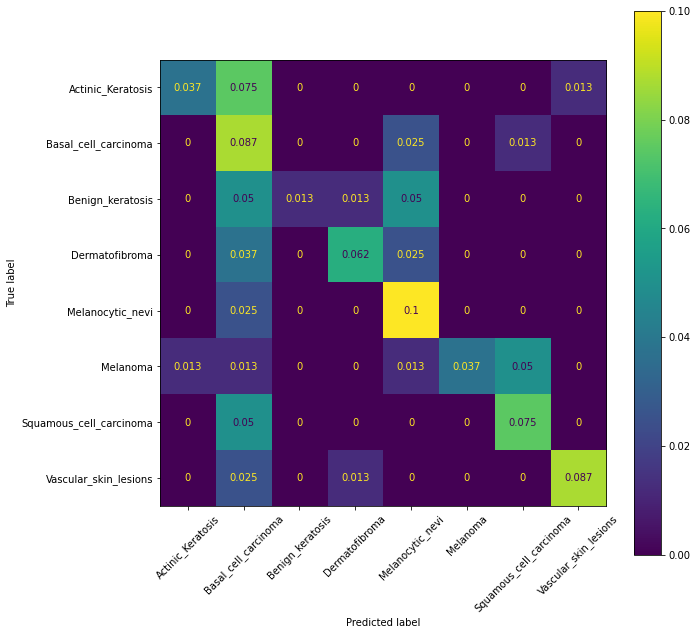

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


names = ['Actinic_Keratosis', 'Basal_cell_carcinoma', 'Benign_keratosis',
         'Dermatofibroma', 'Melanocytic_nevi', 'Melanoma', 'Squamous_cell_carcinoma', 'Vascular_skin_lesions']


#test_data_dir = '/content/gdrive/My Drive/Colab Notebooks/Clasificador/predict'
test_data_dir = '/content/gdrive/My Drive/Colab Notebooks/Clasificador/data/test'

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

custom_Model= load_model("/content/gdrive/My Drive/Colab Notebooks/Clasificador/modelo/custom_model_VGG16.h5")
#modelt = custom_model

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes


cm = confusion_matrix(y_real, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, xticks_rotation=45)

print(metrics.classification_report(y_real,y_pred, digits = 4))